In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Fri May 27 22:15:13 2022

@author: rodrigo
"""

#Cargando librerías 
import importlib

import matplotlib.pyplot as plt
import scipy as sp
import numpy as np
import pandas as pd
import os
import sys  

root = os.getcwd() + "/.."

sys.path.insert(0, root)

import src.positioning_sensors as ps
importlib.reload(ps)

import src.network_fitness as netfit
importlib.reload(netfit)

import src.manageExperiments as me
importlib.reload(me)

import config.config as cfg
importlib.reload(cfg)

from geneticalgorithm import geneticalgorithm as ga

import itertools as it

#read_global_variables

plt.style.use("ggplot")

fn = "linz_with_init_net.txt"
setup = me.readConfigFile(fn)


#cargamos imagenes en luminance e importance
ilumina = setup["folder_input"] + setup["input_ntli"]
niveles = setup["folder_input"] + setup["input_evm"]
sigma_y = setup['filterg_sy']
sigma_x = setup['filterg_sx']
sigma = [sigma_y,sigma_x]

#Loading precalculated local and directed empirical variograms
path2output_semivars = (cfg.experiment 
          + setup["experiment_id"]
          + setup["folder_semivariances"]
          + setup["output_semivariances"] 
                       )


filesv = path2output_semivars + ".csv"
filesvmask = path2output_semivars + "mask.csv"

path2optimum_values_file = (cfg.experiment 
                           + setup["experiment_id"] 
                           + setup["folder_output"] 
                           )

saveOptimumValuesTofile = (path2optimum_values_file
                           + setup["output_values"]
                          )

saveArgsTofile = (path2optimum_values_file
                  + setup["output_args"]
                 )

data = pd.read_csv(filesv)
data_m = pd.read_csv(filesvmask)
variogram_set = np.array(data.iloc[:,3:])
variogram_set_m = np.array(data_m.iloc[:,3:])


#NLTI: luminance
#luminance = ps.readIMG(cfg.data + ilumina)

ilumina = cfg.data + setup["folder_input"] + setup["input_ntli"]
niveles = cfg.data + setup["folder_input"] + setup["input_evm"]

#NTLI: luminance
NTLI = ps.readIMG(ilumina)

FDNTLI = sp.ndimage.filters.gaussian_filter(NTLI, 
                                            sigma, 
                                            mode = setup['gaussian_mode'])



FDNTLI = (FDNTLI>=setup['neglect_values'])*FDNTLI

EAM = ps.readIMG(niveles, invert = True)

EAM[EAM==254]=1.0

th = int(setup["desaturation_th"])

#EAM: Environtmental attention map is the importance
#EAM = ps.readIMG(cfg.data + niveles, invert = True)


#nonsat, b = ps.desaturate(luminance, th = setup["desaturation_th"])

nonsat = FDNTLI
variograms = variogram_set.reshape(len(variogram_set),nonsat.shape[0],nonsat.shape[1])
variograms_m = variogram_set_m.reshape(len(variogram_set),nonsat.shape[0],nonsat.shape[1])

coords = np.array(data.iloc[:,1:3])

from IPython.display import clear_output

r2 = list([])
results2 = list([])




allc = setup["sensitivity_c"]

alls = setup["nsensors"]

L = setup['init_fixed_net']

network = np.array(L).flatten()

R = np.arange(len(L))

/var/folders/k9/wpfgnz550_n_k3t9tg8scnlw0000gn/T/ipykernel_67472/4264779860.py:93: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  FDNTLI = sp.ndimage.filters.gaussian_filter(NTLI,


In [3]:
#sensors allowed to modify their position
n = 1

In [4]:
print("sensibilidad:", allc)
print("sensors extra:", alls)
[i for i in it.product(allc, alls)]

sensibilidad: [1]
sensors extra: [0]


[(1, 0)]

In [5]:
#extra sensors
setup["nsensors"]

[0]

In [6]:
for i in it.product(allc, alls):
    c = i[0]
    n_sensors = i[1]
    print(i)
    
    sensitivity = ps.f5(FDNTLI, EAM, c)
    
    aptitude = netfit.NetworkFitness(FDNTLI,
                                     EAM, 
                                     sensitivity, 
                                     variograms, 
                                     variograms_m,
                                     coords,
                                     network,
                                     n)
    
    aptitude.selectFitnessFunction("max")
    f = aptitude.f
    
    
    

(1, 0)
 W = i*a^(p)
Selct cost functions: 
 'xor','max' or 'cover'


$$C_r^x$$

In [8]:
aptitude.generateCombinations(5, 3)

[(0, 1, 2),
 (0, 1, 3),
 (0, 1, 4),
 (0, 2, 3),
 (0, 2, 4),
 (0, 3, 4),
 (1, 2, 3),
 (1, 2, 4),
 (1, 3, 4),
 (2, 3, 4)]

In [7]:
aptitude.c

[(0,), (1,), (2,), (3,), (4,)]

In [8]:
def generateVarbounds(sensor, image, r):
    
    
    N = len(sensor) 
    
    ix_n = np.arange(N)
    
    varbounds = [[0, image.shape[0]-1], [0,image.shape[1]-1]]*N
    
    #all the combinations
    C = list(it.combinations(ix_n, r))
    
    varbounds.append([0, len(C)-1]) 
    
    
    
    
    return np.array(varbounds)

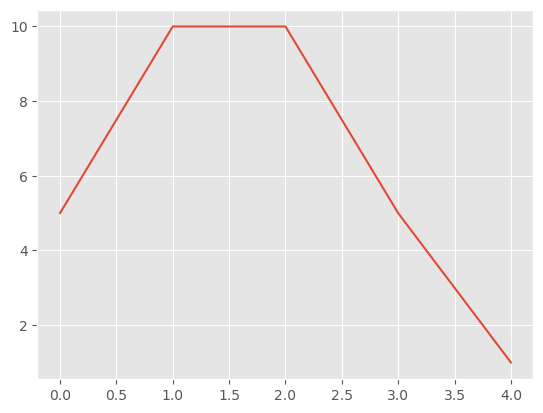

In [9]:
plt.plot([len(list(it.combinations((0,1,2,3,4), i))) for i in [1,2,3,4,5] ])


In [10]:
((NTLI.shape[0]*NTLI.shape[1])**1)*5

18290

In [11]:
((NTLI.shape[0]*NTLI.shape[1])**2)*10

133809640

In [12]:
((NTLI.shape[0]*NTLI.shape[1])**3)*10

489475663120

In [13]:
((NTLI.shape[0]*NTLI.shape[1])**4)*5

895250987846480

In [14]:
((NTLI.shape[0]*NTLI.shape[1])**5)*1

654965622708484768

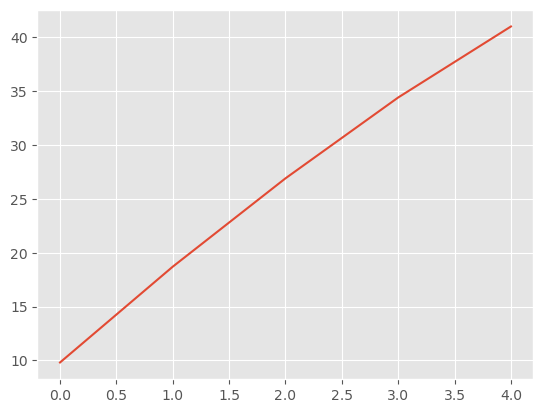

In [15]:
plt.plot(np.log([18290,133809640,489475663120,895250987846480,654965622708484768]))

In [16]:
#: L number of sensors
#: size of the field for the sensors
#: size of the combination of selecting sensors without repetition
vb  = generateVarbounds(L, FDNTLI, n)

In [17]:
algorithm_parameters = setup["ga_params"]

In [18]:
import random
random_pos = [random.randint(r[0], r[1]) for r in vb]

In [19]:
random_pos

[49, 39, 20, 57, 49, 9, 42, 48, 5, 54, 3]

In [20]:
len(random_pos)

11

In [21]:
X = random_pos

In [22]:
aptitude.c

[(0,), (1,), (2,), (3,), (4,)]

In [23]:
aptitude.c[X[-1]]

(3,)

In [24]:
aptitude.init_network

array([34, 34, 34, 31, 35, 29, 36, 39, 39, 22])

In [25]:
s_loc = np.zeros((NTLI.shape[0], NTLI.shape[1]))

In [26]:
s_loc

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

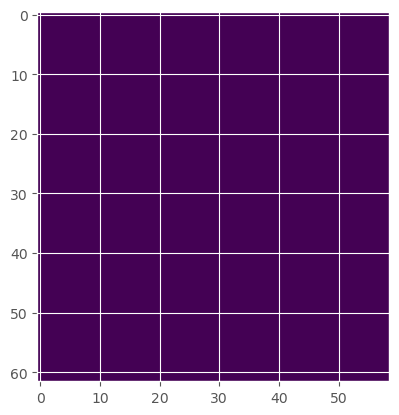

In [27]:
plt.imshow(s_loc)

 The best solution found:                                                                           
 [26. 33. 34. 42. 49.  2. 20. 57. 33. 24.  2.]

 Objective function:
 -0.7870164102245865


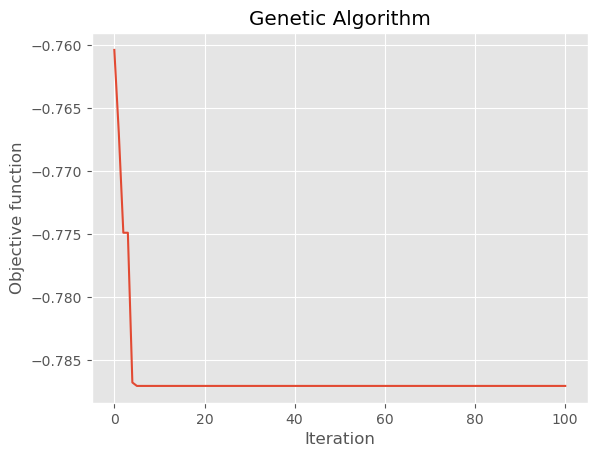

In [28]:

model=ga(function = f,
         dimension = len(vb),
         algorithm_parameters = algorithm_parameters,
         variable_type = 'int',
         variable_boundaries = vb,
         convergence_curve = True
        )

model.run()

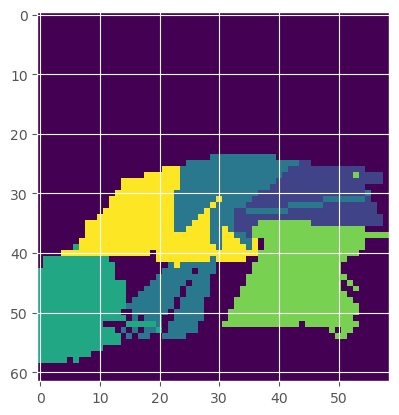

In [30]:
XX = np.array([34, 34, 34, 31, 49, 2, 36, 39, 39, 22])
plt.imshow(aptitude.project(XX))

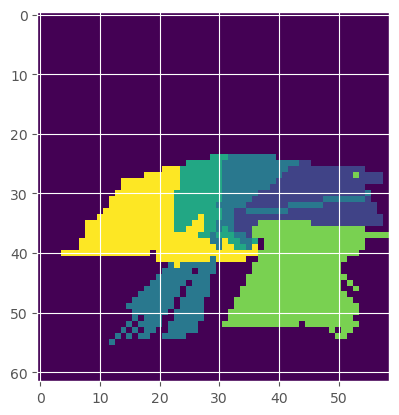

In [31]:
XX = aptitude.init_network
plt.imshow(aptitude.project(XX))

In [32]:
aptitude.init_network

array([34, 34, 34, 31, 35, 29, 36, 39, 39, 22])

In [33]:
empty_space = np.zeros((vb[0][1]+1,vb[1][1]+1))
A = np.copy(aptitude.init_network)
B = model.output_dict['variable']
combinations = aptitude.c

def plotSolution(sensor_list, X, combinations):
    
    
    n = int(len(sensor_list)/2)
    ix_rcs = int(X[-1])
    
    Z = combinations[ix_rcs]
    

    vect_selection = np.zeros(n)
    vect_selection[np.array(Z)] = 1
    
    for ix, x in enumerate(vect_selection):
    
        if x == 1:
            
            sensor_list[ix*2:ix*2+2] = X[ix*2:ix*2+2]
            
    return sensor_list
    
 
    
    
    
    
    
    
    

In [34]:
aptitude.init_network

array([34, 34, 34, 31, 35, 29, 36, 39, 39, 22])

In [35]:
A

array([34, 34, 34, 31, 35, 29, 36, 39, 39, 22])

In [36]:
B

array([26., 33., 34., 42., 49.,  2., 20., 57., 33., 24.,  2.])

In [37]:
model.output_dict['variable']

array([26., 33., 34., 42., 49.,  2., 20., 57., 33., 24.,  2.])

In [38]:
new_net = plotSolution(A, B, combinations)


    

In [39]:
new_net

array([34, 34, 34, 31, 49,  2, 36, 39, 39, 22])

In [40]:
aptitude.init_network

array([34, 34, 34, 31, 35, 29, 36, 39, 39, 22])

In [41]:
aptitude.c[int(model.output_dict['variable'][-1])]

(2,)

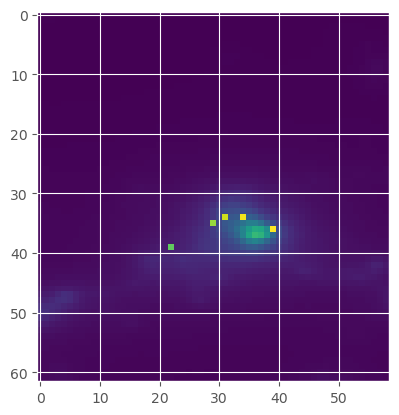

In [42]:

s_loc = np.zeros(NTLI.shape)
psr = np.array(L).flatten().reshape(5, 2)
indices = [tuple(p) for p in psr]
for i in indices:
    s_loc[i] = 1
plt.imshow(s_loc*np.max(NTLI)+NTLI)

In [43]:
A

array([34, 34, 34, 31, 49,  2, 36, 39, 39, 22])

In [44]:
new_net

array([34, 34, 34, 31, 49,  2, 36, 39, 39, 22])

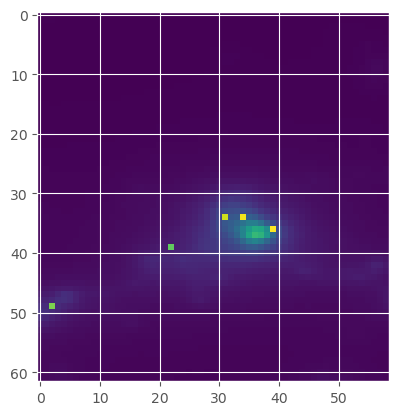

In [45]:

s_loc = np.zeros(NTLI.shape)
psr = new_net.reshape(5, 2)
indices = [tuple(p) for p in psr]
for i in indices:
    s_loc[i] = 1
plt.imshow(s_loc*np.max(NTLI)+NTLI)

In [46]:
for p in psr:

    s_loc[tuple(p)] = 255
    s_loc[tuple(p[0], p[1]+1)] = 1
    s_loc[tuple(p[0], p[1]-1)] = 1
    s_loc[tuple(p[0]+1, p[1])] = 1
    s_loc[tuple(p[0]+1, p[1]-1)] = 1
    s_loc[tuple(p[0]+1, p[1]+1)] = 1

TypeError: tuple expected at most 1 argument, got 2

In [47]:
p[1]+1

35

In [48]:
locations = (np.where(s_loc==1))

In [49]:
s_loc[locations]==1

array([ True,  True,  True,  True])

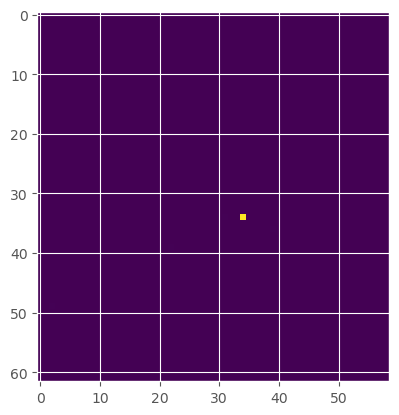

In [50]:
plt.imshow(s_loc)

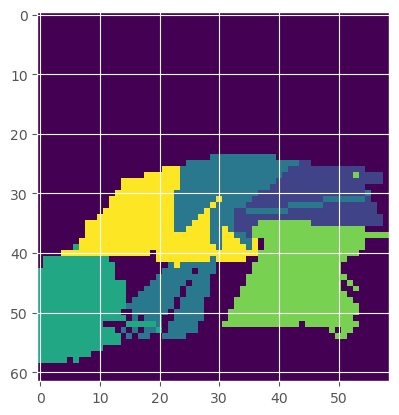

In [51]:
XX = new_net
plt.imshow(aptitude.project(XX))

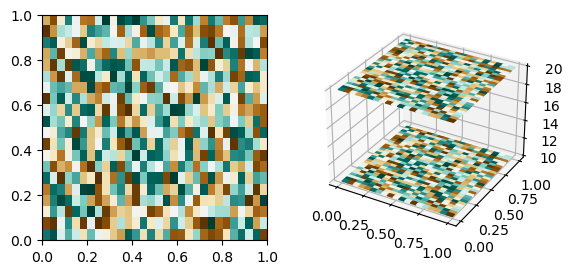

In [27]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# create a 21 x 21 vertex mesh
xx, yy = np.meshgrid(np.linspace(0,1,20), np.linspace(0,1,30))

# create some dummy data (20 x 20) for the image
data = np.random.random((20, 30))

# create vertices for a rotated mesh (3D rotation matrix)
X = np.sqrt(1./3) * xx + np.sqrt(1./3) * yy
X = xx
Y = -np.sqrt(1./3) * xx + np.sqrt(1./3) * yy
Y = yy
Z = np.ones((30,20))*10
Z1 = np.ones((30,20))*20

# create the figure
fig = plt.figure()

# show the reference image
ax1 = fig.add_subplot(121)
ax1.imshow(data, cmap=plt.cm.BrBG, interpolation='nearest', origin='lower', extent=[0,1,0,1])

# show the 3D rotated projection
ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(X, Y, Z, rstride=1, cstride=1, facecolors=plt.cm.BrBG(data.T), shade=False)
ax2.plot_surface(X, Y, Z1, rstride=1, cstride=1, facecolors=plt.cm.BrBG(data.T), shade=False)

In [9]:
(np.sqrt(1./3) * xx - np.sqrt(1./3) * yy).shape

(21, 21)

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1.,